In [6]:
%pip install -q diffusers

Note: you may need to restart the kernel to use updated packages.


In [11]:
!pip install --upgrade -q wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.2 MB/s eta 0:00:00:00:0100:01


In [13]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()

wandb_api = user_secrets.get_secret("wandb_token") 

wandb.login(key=wandb_api)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vamsee-ny1 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [2]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

class PolygonDataset(Dataset):
    def __init__(self,
                 json_path: str,
                 shapes_dir: str,
                 outputs_dir: str,
                 transform=None):
        # 1) Load JSON (could be a list or a dict with "root")
        with open(json_path, 'r') as f:
            data = json.load(f)
        if isinstance(data, dict) and "root" in data:
            self.entries = data["root"]
        elif isinstance(data, list):
            self.entries = data
        else:
            raise RuntimeError(f"Unexpected JSON structure: {type(data)}")

        self.shapes_dir  = shapes_dir
        self.outputs_dir = outputs_dir

        # 2) Build string → index mappings
        shapes_set  = {e['input_polygon'].split('.')[0] for e in self.entries}
        colours_set = {e['colour']                  for e in self.entries}
        self.shape2idx  = {s: i for i, s in enumerate(sorted(shapes_set))}
        self.colour2idx = {c: i for i, c in enumerate(sorted(colours_set))}

        # 3) Transform: ToTensor + normalize to [-1,1]
        self.transform = transform or T.Compose([
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        item = self.entries[idx]

        # load the shape-only PNG
        shape_name = item['input_polygon']
        shape_path = os.path.join(self.shapes_dir, shape_name)
        shape_img  = Image.open(shape_path).convert('RGB')
        shape_img  = self.transform(shape_img)

        # load the colored output PNG
        target_name = item['output_image']
        target_path = os.path.join(self.outputs_dir, target_name)
        target_img  = Image.open(target_path).convert('RGB')
        target_img  = self.transform(target_img)

        # map to integer labels
        shape_lbl  = self.shape2idx[shape_name.split('.')[0]]
        colour_lbl = self.colour2idx[item['colour']]

        return shape_img, target_img, shape_lbl, colour_lbl

In [3]:
from torch.utils.data import DataLoader

train_ds = PolygonDataset(
    json_path   = '/kaggle/input/ayna-test/dataset/training/data.json',
    shapes_dir  = '/kaggle/input/ayna-test/dataset/training/inputs',
    outputs_dir = '/kaggle/input/ayna-test/dataset/training/outputs',
)

train_loader = DataLoader(
    train_ds,
    batch_size  = 32,
    shuffle     = True,
    #num_workers = 2,
    pin_memory  = True
)


In [4]:
from torch.utils.data import DataLoader

val_ds = PolygonDataset(
    json_path   = '/kaggle/input/ayna-test/dataset/validation/data.json',
    shapes_dir  = '/kaggle/input/ayna-test/dataset/validation/inputs',
    outputs_dir = '/kaggle/input/ayna-test/dataset/validation/outputs',
)

val_loader = DataLoader(
    val_ds,
    batch_size  = 32,
    shuffle     = False,
    #num_workers = 2,
    pin_memory  = True
)


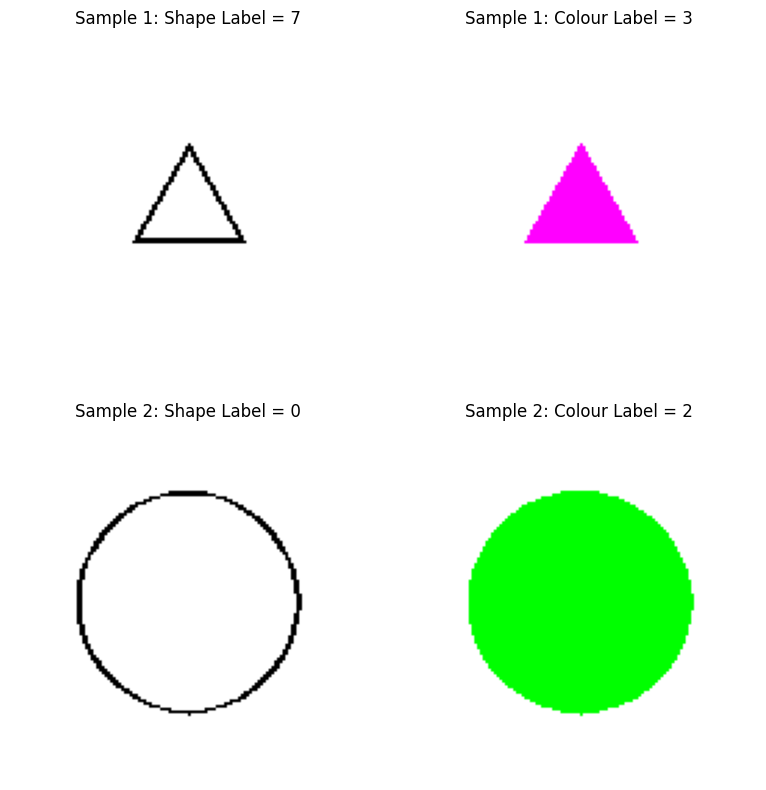

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Utility to unnormalize and plot a tensor image
def imshow(img_tensor, ax, title=None):
    # Clone, move to CPU, unnormalize from [-1,1] → [0,1]
    img = img_tensor.clone().cpu()
    img = img * 0.5 + 0.5
    np_img = img.numpy().transpose((1, 2, 0))
    ax.imshow(np_img)
    if title:
        ax.set_title(title)
    ax.axis('off')

# Grab one batch
data_iter = iter(train_loader)
shape_imgs, target_imgs, shape_lbls, colour_lbls = next(data_iter)

# Set up a 2×2 grid: each row is one sample (outline | colored)
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):
    # Outline-only image
    imshow(
        shape_imgs[i],
        axes[i, 0],
        title=f"Sample {i+1}: Shape Label = {shape_lbls[i].item()}"
    )
    # Colored target image
    imshow(
        target_imgs[i],
        axes[i, 1],
        title=f"Sample {i+1}: Colour Label = {colour_lbls[i].item()}"
    )

plt.tight_layout()
plt.show()

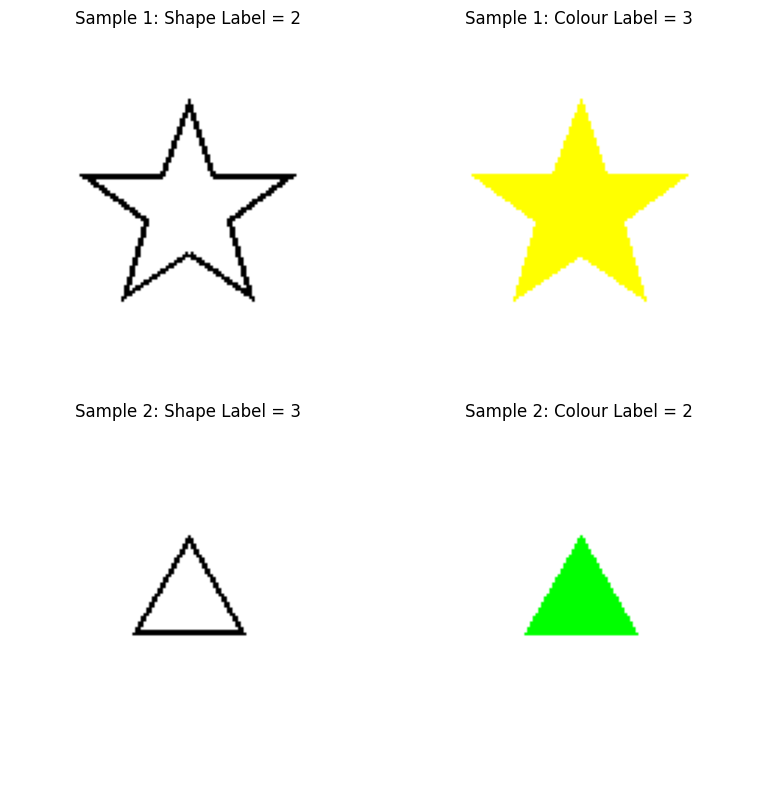

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Utility to unnormalize and plot a tensor image
def imshow(img_tensor, ax, title=None):
    # Clone, move to CPU, unnormalize from [-1,1] → [0,1]
    img = img_tensor.clone().cpu()
    img = img * 0.5 + 0.5
    np_img = img.numpy().transpose((1, 2, 0))
    ax.imshow(np_img)
    if title:
        ax.set_title(title)
    ax.axis('off')

# Grab one batch
data_iter = iter(val_loader)
shape_imgs, target_imgs, shape_lbls, colour_lbls = next(data_iter)

# Set up a 2×2 grid: each row is one sample (outline | colored)
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):
    # Outline-only image
    imshow(
        shape_imgs[i],
        axes[i, 0],
        title=f"Sample {i+1}: Shape Label = {shape_lbls[i].item()}"
    )
    # Colored target image
    imshow(
        target_imgs[i],
        axes[i, 1],
        title=f"Sample {i+1}: Colour Label = {colour_lbls[i].item()}"
    )

plt.tight_layout()
plt.show()

Early stopping enabled: patience=8, min_delta=0.0001
Epoch 1/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100 — Train Loss: 1.0264, Val Loss: 0.8401
✓ Validation loss improved to 0.8401, model saved!
Epoch 2/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100 — Train Loss: 0.7141, Val Loss: 0.6804
✓ Validation loss improved to 0.6804, model saved!
Epoch 3/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100 — Train Loss: 0.5207, Val Loss: 0.4081
✓ Validation loss improved to 0.4081, model saved!
Epoch 4/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100 — Train Loss: 0.4259, Val Loss: 0.2793
✓ Validation loss improved to 0.2793, model saved!
Epoch 5/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100 — Train Loss: 0.3185, Val Loss: 0.3077
⏳ No improvement in validation loss for 1/8 epochs.
Epoch 6/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100 — Train Loss: 0.3012, Val Loss: 0.2565
✓ Validation loss improved to 0.2565, model saved!
Epoch 7/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100 — Train Loss: 0.2450, Val Loss: 0.1601
✓ Validation loss improved to 0.1601, model saved!
Epoch 8/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100 — Train Loss: 0.2203, Val Loss: 0.1481
✓ Validation loss improved to 0.1481, model saved!
Epoch 9/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100 — Train Loss: 0.1983, Val Loss: 0.2832
⏳ No improvement in validation loss for 1/8 epochs.
Epoch 10/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100 — Train Loss: 0.1864, Val Loss: 0.2042
⏳ No improvement in validation loss for 2/8 epochs.
Epoch 11/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100 — Train Loss: 0.1737, Val Loss: 0.1193
✓ Validation loss improved to 0.1193, model saved!
Epoch 12/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100 — Train Loss: 0.1635, Val Loss: 0.1201
⏳ No improvement in validation loss for 1/8 epochs.
Epoch 13/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100 — Train Loss: 0.1414, Val Loss: 0.1147
✓ Validation loss improved to 0.1147, model saved!
Epoch 14/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100 — Train Loss: 0.1324, Val Loss: 0.2927
⏳ No improvement in validation loss for 1/8 epochs.
Epoch 15/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100 — Train Loss: 0.1229, Val Loss: 0.1468
⏳ No improvement in validation loss for 2/8 epochs.
Epoch 16/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100 — Train Loss: 0.1159, Val Loss: 0.1511
⏳ No improvement in validation loss for 3/8 epochs.
Epoch 17/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100 — Train Loss: 0.1159, Val Loss: 0.1207
⏳ No improvement in validation loss for 4/8 epochs.
Epoch 18/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100 — Train Loss: 0.1027, Val Loss: 0.0863
✓ Validation loss improved to 0.0863, model saved!
Epoch 19/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100 — Train Loss: 0.1319, Val Loss: 0.1011
⏳ No improvement in validation loss for 1/8 epochs.
Epoch 20/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100 — Train Loss: 0.1372, Val Loss: 0.2182
⏳ No improvement in validation loss for 2/8 epochs.
Epoch 21/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100 — Train Loss: 0.0927, Val Loss: 0.0848
✓ Validation loss improved to 0.0848, model saved!
Epoch 22/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100 — Train Loss: 0.0929, Val Loss: 0.0731
✓ Validation loss improved to 0.0731, model saved!
Epoch 23/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100 — Train Loss: 0.1011, Val Loss: 0.1007
⏳ No improvement in validation loss for 1/8 epochs.
Epoch 24/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100 — Train Loss: 0.1158, Val Loss: 0.1772
⏳ No improvement in validation loss for 2/8 epochs.
Epoch 25/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100 — Train Loss: 0.0875, Val Loss: 0.0868
⏳ No improvement in validation loss for 3/8 epochs.
Epoch 26/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100 — Train Loss: 0.1023, Val Loss: 0.0753
⏳ No improvement in validation loss for 4/8 epochs.
Epoch 27/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100 — Train Loss: 0.0862, Val Loss: 0.0800
⏳ No improvement in validation loss for 5/8 epochs.
Epoch 28/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100 — Train Loss: 0.0885, Val Loss: 0.0608
✓ Validation loss improved to 0.0608, model saved!
Epoch 29/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100 — Train Loss: 0.0894, Val Loss: 0.0675
⏳ No improvement in validation loss for 1/8 epochs.
Epoch 30/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100 — Train Loss: 0.0838, Val Loss: 0.0769
⏳ No improvement in validation loss for 2/8 epochs.
Epoch 31/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100 — Train Loss: 0.0853, Val Loss: 0.0720
⏳ No improvement in validation loss for 3/8 epochs.
Epoch 32/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100 — Train Loss: 0.0805, Val Loss: 0.0583
✓ Validation loss improved to 0.0583, model saved!
Epoch 33/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100 — Train Loss: 0.0782, Val Loss: 0.0492
✓ Validation loss improved to 0.0492, model saved!
Epoch 34/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100 — Train Loss: 0.0795, Val Loss: 0.1237
⏳ No improvement in validation loss for 1/8 epochs.
Epoch 35/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100 — Train Loss: 0.0814, Val Loss: 0.0621
⏳ No improvement in validation loss for 2/8 epochs.
Epoch 36/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100 — Train Loss: 0.0925, Val Loss: 0.0862
⏳ No improvement in validation loss for 3/8 epochs.
Epoch 37/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100 — Train Loss: 0.0951, Val Loss: 0.0661
⏳ No improvement in validation loss for 4/8 epochs.
Epoch 38/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100 — Train Loss: 0.0785, Val Loss: 0.0545
⏳ No improvement in validation loss for 5/8 epochs.
Epoch 39/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100 — Train Loss: 0.0682, Val Loss: 0.0549
⏳ No improvement in validation loss for 6/8 epochs.
Epoch 40/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100 — Train Loss: 0.0739, Val Loss: 0.0560
⏳ No improvement in validation loss for 7/8 epochs.
Epoch 41/100 - Training...


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41/100 - Validation...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100 — Train Loss: 0.0731, Val Loss: 0.0841
⏳ No improvement in validation loss for 8/8 epochs.
🛑 Early stopping triggered! Best validation loss: 0.0492
Loading best model weights...
Loaded model from epoch 33 with val loss 0.0492


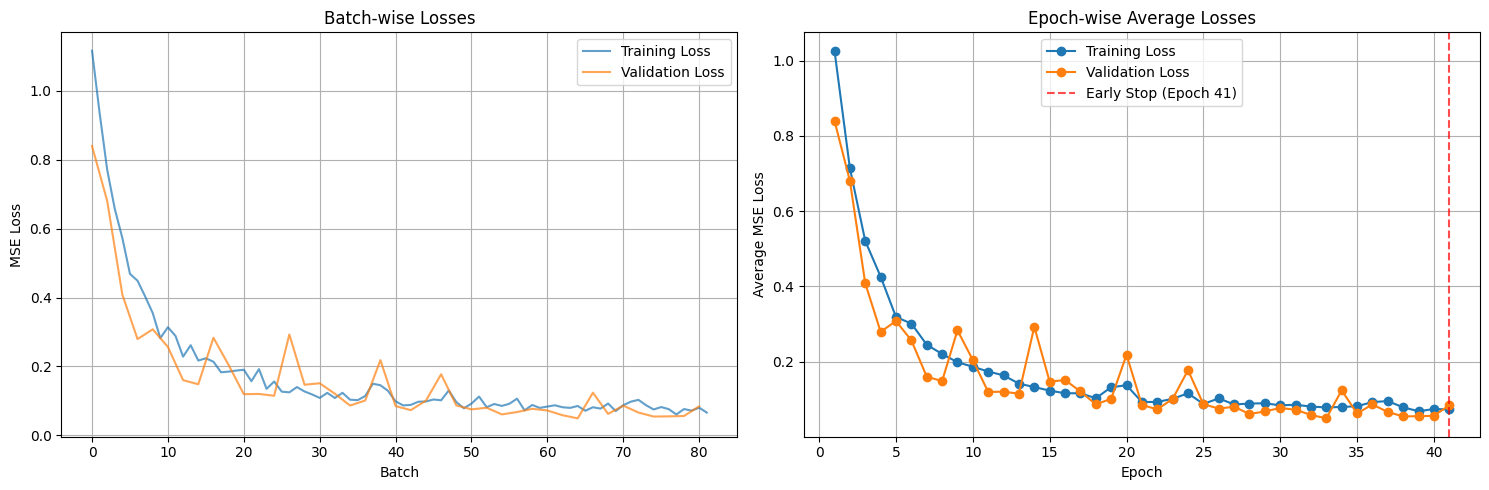


Training Summary:
Total epochs completed: 41
Best validation loss: 0.0492
Final training loss: 0.0731
Final validation loss: 0.0841
Training stopped early due to no improvement for 8 epochs.


best_model_epoch,▁▁▁▂▂▂▃▃▄▅▅▆▇██
best_val_loss,█▇▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
final_train_loss,▁
final_val_loss,▁
patience_counter,▁▁▁▁▁▂▁▁▁▂▃▁▂▁▂▃▄▅▁▂▃▁▁▂▃▄▅▆▁▂▃▄▁▁▂▃▄▅▆█
total_epochs,▁
train_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▃▃▂▂▃▂▂▂▂▃▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
best_model_epoch,33
best_val_loss,0.04924


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from diffusers import UNet2DModel, DDPMScheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 1) Define the model
class PolygonConditionedUnet(nn.Module):
    def __init__(
        self,
        num_shapes: int,
        num_colours: int,
        shape_emb_size: int = 8,
        colour_emb_size: int = 8,
        sample_size: int = 128,
    ):
        super().__init__()
        self.shape_emb  = nn.Embedding(num_shapes,  shape_emb_size)
        self.colour_emb = nn.Embedding(num_colours, colour_emb_size)
        self.model = UNet2DModel(
            sample_size=sample_size,
            in_channels=3 + shape_emb_size + colour_emb_size,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            ),
        )

    def forward(self, x, t, shape_labels, colour_labels):
        bs, ch, H, W = x.shape
        sh = self.shape_emb(shape_labels).view(bs, -1, 1, 1).expand(bs, -1, H, W)
        co = self.colour_emb(colour_labels).view(bs, -1, 1, 1).expand(bs, -1, H, W)
        net_input = torch.cat([x, sh, co], dim=1)
        return self.model(net_input, t).sample

# 2) Instantiate dataset + loaders
# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

# 3) Setup device, model, scheduler, optimizer, loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_shapes  = train_loader.dataset.shape2idx.__len__()
num_colours = train_loader.dataset.colour2idx.__len__()
net = PolygonConditionedUnet(num_shapes, num_colours, sample_size=128).to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ===== WANDB INITIALIZATION =====
wandb.init(
    project="polygon-diffusion",        # Your project name
    name="unet-training-run",           # This run's name
    config={                            # Log hyperparameters
        "epochs": 100,
        "batch_size": train_loader.batch_size,
        "learning_rate": 1e-3,
        "patience": 8,
        "min_delta": 1e-4,
        "num_shapes": num_shapes,
        "num_colours": num_colours,
        "sample_size": 128,
        "beta_schedule": "squaredcos_cap_v2"
    }
)

# Watch the model (optional - tracks gradients and model topology)
wandb.watch(net, log='all')

# Store losses for both training and validation
train_losses = []
val_losses = []
epoch_train_losses = []
epoch_val_losses = []

# ===== EARLY STOPPING PARAMETERS =====
patience = 8  # Number of epochs to wait for improvement
min_delta = 1e-4  # Minimum change to qualify as improvement
best_val_loss = float('inf')
patience_counter = 0
early_stopped = False

print(f"Early stopping enabled: patience={patience}, min_delta={min_delta}")

# 4) Training loop with validation and early stopping
n_epochs = 100  # Set higher since early stopping will handle it
for epoch in range(n_epochs):
    
    # ============ TRAINING PHASE ============
    net.train()  # Set model to training mode
    epoch_train_loss = 0
    num_train_batches = 0
    
    print(f"Epoch {epoch+1}/{n_epochs} - Training...")
    for outlines, targets, s_lbls, c_lbls in tqdm(train_loader, desc="Training"):
        outlines = outlines.to(device) * 2 - 1    # Normalize to [-1,1]
        targets  = targets.to(device) * 2 - 1
        s_lbls   = s_lbls.to(device)
        c_lbls   = c_lbls.to(device)

        # Sample noise & timesteps
        noise     = torch.randn_like(targets)
        timesteps = torch.randint(0, 1000, (targets.size(0),), device=device).long()
        noisy_tgt = noise_scheduler.add_noise(targets, noise, timesteps)

        # Forward pass
        pred_noise = net(noisy_tgt, timesteps, s_lbls, c_lbls)

        # Compute loss and backprop
        loss = loss_fn(pred_noise, noise)
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Track losses
        train_losses.append(loss.item())
        epoch_train_loss += loss.item()
        num_train_batches += 1

    # ============ VALIDATION PHASE ============
    net.eval()  # Set model to evaluation mode
    epoch_val_loss = 0
    num_val_batches = 0
    
    print(f"Epoch {epoch+1}/{n_epochs} - Validation...")
    with torch.no_grad():  # Disable gradient computation for validation
        for outlines, targets, s_lbls, c_lbls in tqdm(val_loader, desc="Validation"):
            outlines = outlines.to(device) * 2 - 1
            targets  = targets.to(device) * 2 - 1
            s_lbls   = s_lbls.to(device)
            c_lbls   = c_lbls.to(device)

            # Sample noise & timesteps
            noise     = torch.randn_like(targets)
            timesteps = torch.randint(0, 1000, (targets.size(0),), device=device).long()
            noisy_tgt = noise_scheduler.add_noise(targets, noise, timesteps)

            # Forward pass (no backward pass in validation)
            pred_noise = net(noisy_tgt, timesteps, s_lbls, c_lbls)
            
            # Compute validation loss
            val_loss = loss_fn(pred_noise, noise)
            val_losses.append(val_loss.item())
            epoch_val_loss += val_loss.item()
            num_val_batches += 1

    # Calculate average losses for the epoch
    avg_train_loss = epoch_train_loss / num_train_batches
    avg_val_loss = epoch_val_loss / num_val_batches
    
    # Store epoch averages
    epoch_train_losses.append(avg_train_loss)
    epoch_val_losses.append(avg_val_loss)

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "best_val_loss": best_val_loss,
        "patience_counter": patience_counter
    })
    
    # Print epoch summary
    print(f'Epoch {epoch+1}/{n_epochs} — Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # ===== EARLY STOPPING CHECK =====
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'best_val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'epoch_train_losses': epoch_train_losses,
            'epoch_val_losses': epoch_val_losses
        }, 'best_model.pth')

        # ===== LOG MODEL TO WANDB =====
        wandb.save('best_model.pth')  # Upload checkpoint to wandb
        wandb.log({"best_model_epoch": epoch + 1})
        
        print(f'✓ Validation loss improved to {best_val_loss:.4f}, model saved!')
    else:
        patience_counter += 1
        print(f'⏳ No improvement in validation loss for {patience_counter}/{patience} epochs.')
        
        if patience_counter >= patience:
            print(f'🛑 Early stopping triggered! Best validation loss: {best_val_loss:.4f}')
            early_stopped = True
            break

# Load best model for inference
if early_stopped:
    print("Loading best model weights...")
    checkpoint = torch.load('best_model.pth')
    net.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from epoch {checkpoint['epoch']+1} with val loss {checkpoint['best_val_loss']:.4f}")

# 5) Plot losses with early stopping indicator
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot batch-wise losses
ax1.plot(train_losses, label='Training Loss', alpha=0.7)
if len(val_losses) > 0:
    # Adjust val loss plotting for proper alignment
    val_x = range(0, len(val_losses) * len(train_loader), len(train_loader))[:len(val_losses)]
    ax1.plot(val_x, val_losses[::max(1, len(val_losses)//len(epoch_val_losses))], 
             label='Validation Loss', alpha=0.7)
ax1.set_xlabel('Batch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Batch-wise Losses')
ax1.legend()
ax1.grid(True)

# Plot epoch-wise average losses
epochs_completed = range(1, len(epoch_train_losses) + 1)
ax2.plot(epochs_completed, epoch_train_losses, 'o-', label='Training Loss')
ax2.plot(epochs_completed, epoch_val_losses, 'o-', label='Validation Loss')

# Mark early stopping point
if early_stopped:
    ax2.axvline(x=len(epoch_train_losses), color='red', linestyle='--', alpha=0.7, 
                label=f'Early Stop (Epoch {len(epoch_train_losses)})')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average MSE Loss')
ax2.set_title('Epoch-wise Average Losses')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\nTraining Summary:")
print(f"Total epochs completed: {len(epoch_train_losses)}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final training loss: {epoch_train_losses[-1]:.4f}")
print(f"Final validation loss: {epoch_val_losses[-1]:.4f}")
if early_stopped:
    print(f"Training stopped early due to no improvement for {patience} epochs.")
else:
    print(f"Training completed all {n_epochs} epochs.")


# ===== FINISH WANDB RUN =====
wandb.log({
    "final_train_loss": epoch_train_losses[-1],
    "final_val_loss": epoch_val_losses[-1],
    "total_epochs": len(epoch_train_losses),
    "early_stopped": early_stopped
})
wandb.finish()


Generating square in red...


  0%|          | 0/1000 [00:00<?, ?it/s]

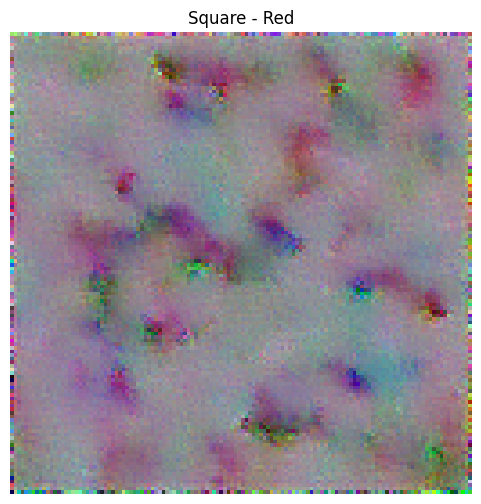

In [10]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Load your trained model (if not already loaded)
# net.load_state_dict(torch.load('best_model.pth'))
net.eval()

# Get the mappings from your dataset (replace with your actual mappings)
shape2idx = train_loader.dataset.shape2idx
colour2idx = train_loader.dataset.colour2idx

# OR define them manually if you know them:
# shape2idx = {'triangle': 0, 'circle': 1, 'square': 2}
# colour2idx = {'red': 0, 'green': 1, 'blue': 2}

def generate_single_image(shape_str, color_str):
    """Generate a single image from shape and color strings"""
    
    # Convert strings to numbers
    shape_label = torch.tensor([shape2idx[shape_str]], device=device)
    color_label = torch.tensor([colour2idx[color_str]], device=device)
    
    # Start with random noise (1 image, 3 channels, 128x128)
    x = torch.randn(1, 3, 128, 128, device=device)
    
    # Generate the image step by step
    print(f"Generating {shape_str} in {color_str}...")
    for t in tqdm(noise_scheduler.timesteps):
        with torch.no_grad():
            # Predict noise
            predicted_noise = net(x, torch.tensor([t], device=device), shape_label, color_label)
            # Remove noise
            x = noise_scheduler.step(predicted_noise, t, x).prev_sample
    
    return x

def show_single_image(image, shape_str, color_str):
    """Display a single generated image"""
    # Convert from [-1,1] to [0,1] for display
    img = (image[0].cpu() + 1) / 2
    
    # Show the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"{shape_str.title()} - {color_str.title()}")
    plt.axis('off')
    plt.show()

# ===== USAGE: Generate 1 image =====
shape = "square"    # Replace with your desired shape
color = "red"       # Replace with your desired color

# Generate the image
generated_image = generate_single_image(shape, color)

# Display it
show_single_image(generated_image, shape, color)

In [23]:
# Check available shapes and colors from your dataset
print("Available shapes:", list(train_loader.dataset.shape2idx.keys()))
print("Available colours:", list(train_loader.dataset.colour2idx.keys()))

Available shapes: ['circle', 'diamond', 'hexagon', 'octagon', 'pentagon', 'square', 'star', 'triangle']
Available colours: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']
